# Evaluation and submission analysis for DeepRacer

This notebook has been built based on the `DeepRacer Log Analysis.ipynb` provided by the AWS DeepRacer Team. It has been reorganised and expanded to provide new views on the evaluation/racing data in a cleaner way, without the helper code which was moved into utility `.py` files.

**You will find this notebook most useful for race submissions reviews and because of that it is mostly focusing on this goal.**

## Usage

I am assuming here that you have already become familiar with `Training_analysis.ipynb`. Therefore descriptions that you will find here may be missing some bits if already described in there.

Since this file can change in the future, I recommend that you make its copy and reorganize it to your liking. This way you will not lose your changes and you'll be able to add things as you please.

**This notebook isn't complete.** What I find interesting in the logs may not be what you will find interesting and useful. I recommend you get familiar with the tools and try hacking around to get the insights that suit your needs.

## Contributions

As usual, your ideas are very welcome and encouraged so if you have any suggestions either bring them to [the AWS DeepRacer Community](http://join.deepracing.io) or share as code contributions.

## Training environments

Depending on whether you're running your evaluations through the console or using the local setup, and on which setup for local training you're using, your experience will vary. As much as I would like everything to be taylored to your configuration, there may be some problems that you may face. If so, please get in touch through [the AWS DeepRacer Community](http://join.deepracing.io).

For race submissions it is much more straightforward.

## Requirements

Before you start using the notebook, you will need to install some dependencies. If you haven't yet done so, have a look at [The README.md file](/edit/README.md#running-the-notebooks) to find what you need to install.

Apart from the install, you also have to configure your programmatic access to AWS. Have a look at the guides below, AWS resources will lead you by the hand:

AWS CLI: https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html

Boto Configuration: https://boto3.amazonaws.com/v1/documentation/api/latest/guide/configuration.html

## Credits

I would like to thank [the AWS DeepRacer Community](http://join.deepracing.io) for all the feedback about the notebooks. If you'd like, follow [my blog](https://codelikeamother.uk) where I tend to write about my experiences with AWS DeepRacer.

# Log Analysis

Let's get to it.

## Imports

Run the imports block below:

In [1]:
import sys

!{sys.executable} -m pip install --upgrade deepracer-utils

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:

from deepracer.tracks import TrackIO, Track

from deepracer.logs import \
    AnalysisUtils as au, \
    SimulationLogsIO as slio, \
    EvaluationUtils as eu, \
    PlottingUtils as pu , \
    DeepRacerLog

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')

## Load waypoints for the track you want to run analysis on

You will notice files for racing tracks. They are community best-effort versions made to make the visualisation in the logs less confusing. They may be slightly differing from reality, we don't know for sure. We do not have access to actual npy files that AWS use in the league.

Tracks Available:

In [3]:
!ls tracks/

tu = TrackIO()

caecer_loop.npy  Oval_track.npy


Loaded 121 waypoints


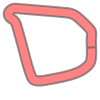

In [4]:
track: Track = tu.load_track("caecer_loop")

track.road_poly

## Load all race submission logs

**WARNING:** If you do not specify `not_older_than` parameter, all evaluation logs will be downloaded. They aren't as big as the training logs, but there is a lot of them.

That said you can download all and then it will only download new ones unless you use force=True.

There are also `not_older_than` and `older_than` parameters so you can choose to fetch all logs from a given period and compare them against each other. Just remember memory is finite.

As mentioned, this method always fetches a list of log streams and then downloads only ones that haven't been downloaded just yet. You can therefore use it to fetch that list and load all the files from the path provided.

Side note: if you want to download evaluation logs from AWS DeepRacer Console, this will be a bit more tricky. Evaluation logs are grouped together with training logs in same group `/aws/robomaker/SimulationJobs` and there isn't an obvious way to recognise which ones they are. That said, in `Evaluation Run Analysis` section below you have the ability to download a single evaluation file.

In [5]:
# For the purpose of generating the notebook in a reproducible way
# logs download has been commented out.
#logs = [('logs/sample-logs/logs/evaluation/evaluation-20211216205351-93q8omZcSLOGRZRY9BbkRg-robomaker', 'sim-trace')]

logs = [('logs/cornering-clone/logs/evaluation/evaluation-20211216234207-SoZjK8EXQ-qE7PT-osZpdQ-robomaker.log', 'sim-sample')]

# load logs into a dataframe
#log.load()


# logs = cw.download_all_logs(
#     'logs/deepracer-eval-', 
#     '/aws/deepracer/leaderboard/SimulationJobs', 
#     not_older_than="2019-07-01 07:00", 
#     older_than="2019-07-01 12:00"
# )

In [6]:
# Loads all the logs from the above time range
bulk = slio.load_a_list_of_logs(logs)

## Parse logs and visualize

You will notice in here that reward graps are missing, as are many others from the training. These have been trimmed down for clarity.

Do not get tricked though - this notebook provides features that the training one doesn't have, such as batch visualisation of race submission laps.

Side note: Evaluation/race logs contain a reward field but it's not connected to your reward. It is there most likely to ensure logs have consistent structure to make their parsing easier. The value appears to be dependand on distance of the car from the centre of the track. As such it provides no value and is not visualised in this notebook.

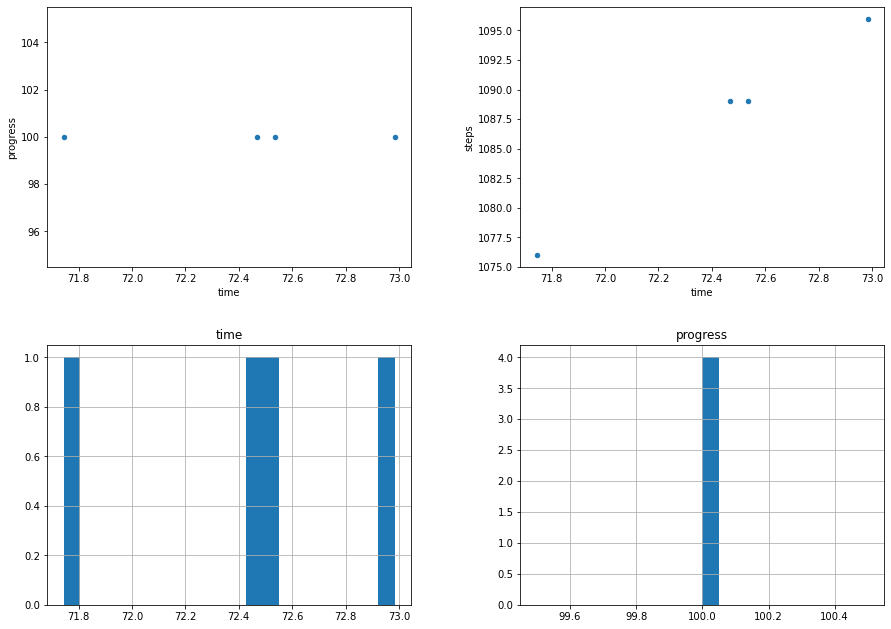

<Figure size 432x288 with 0 Axes>

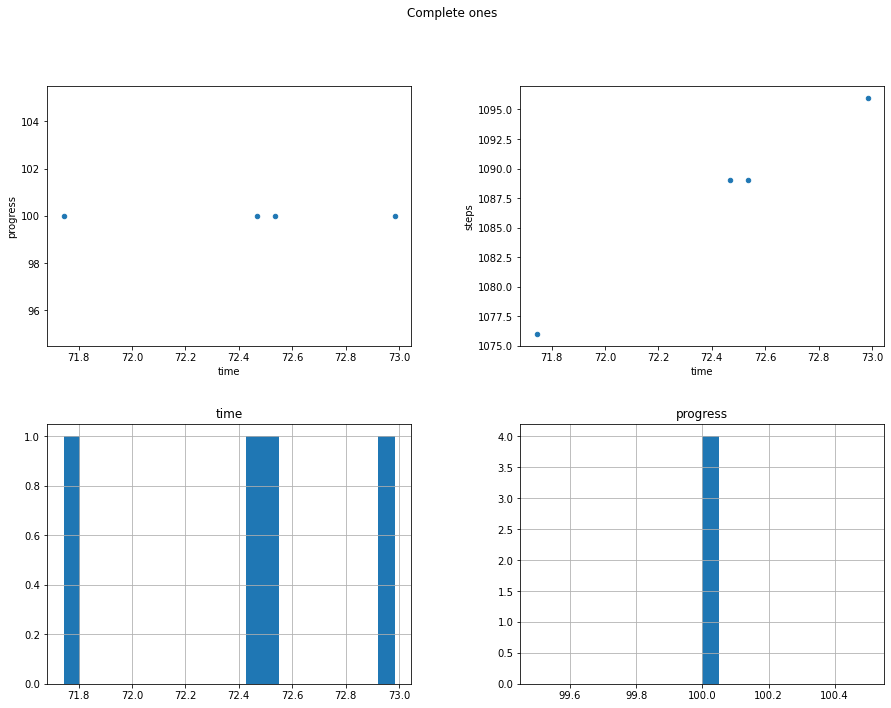

<Figure size 432x288 with 0 Axes>

In [7]:
simulation_agg = au.simulation_agg(bulk, 'stream', add_tstamp=True, is_eval=True)
complete_ones = simulation_agg[simulation_agg['progress']==100]

# This gives the warning about ptp method deprecation. The code looks as if np.ptp was used, I don't know how to fix it.
au.scatter_aggregates(simulation_agg, is_eval=True)
if complete_ones.shape[0] > 0:
    au.scatter_aggregates(complete_ones, "Complete ones", is_eval=True)

## Data in tables

In [8]:
# View fifteen most progressed attempts
simulation_agg.nlargest(15, 'progress')

,stream,episode,steps,start_at,progress,time,speed,time_if_complete,tstamp
0,sim-sample,0,1089,0,100.0,72.469,0.451426,72.469,1970-01-01 00:01:18.674
1,sim-sample,1,1076,0,100.0,71.745,0.453532,71.745,1970-01-01 00:02:30.538
2,sim-sample,2,1096,0,100.0,72.984,0.451095,72.984,1970-01-01 00:03:43.655
3,sim-sample,3,1089,0,100.0,72.534,0.451331,72.534,1970-01-01 00:04:56.331


In [9]:
# View fifteen fastest complete laps
complete_ones.nsmallest(15, 'time')

,stream,episode,steps,start_at,progress,time,speed,time_if_complete,tstamp
1,sim-sample,1,1076,0,100.0,71.745,0.453532,71.745,1970-01-01 00:02:30.538
0,sim-sample,0,1089,0,100.0,72.469,0.451426,72.469,1970-01-01 00:01:18.674
3,sim-sample,3,1089,0,100.0,72.534,0.451331,72.534,1970-01-01 00:04:56.331
2,sim-sample,2,1096,0,100.0,72.984,0.451095,72.984,1970-01-01 00:03:43.655


In [10]:
# View ten most recent lap attempts
simulation_agg.nlargest(10, 'tstamp')

,stream,episode,steps,start_at,progress,time,speed,time_if_complete,tstamp
3,sim-sample,3,1089,0,100.0,72.534,0.451331,72.534,1970-01-01 00:04:56.331
2,sim-sample,2,1096,0,100.0,72.984,0.451095,72.984,1970-01-01 00:03:43.655
1,sim-sample,1,1076,0,100.0,71.745,0.453532,71.745,1970-01-01 00:02:30.538
0,sim-sample,0,1089,0,100.0,72.469,0.451426,72.469,1970-01-01 00:01:18.674


## Plot all the evaluation laps

The method below plots your evaluation attempts. Just note that that is a time consuming operation and therefore I suggest using `min_distance_to_plot` to just plot some of them.

If you would like to, in a below section of this article you can load a single log file to evaluate this.

In the example below training track data was used for plotting the borders. Since then the community has put a lot of effort into preparing files that resemble the racing ones.

If you want to plot a single lap, scroll down for an example which lets you do a couple more tricks.

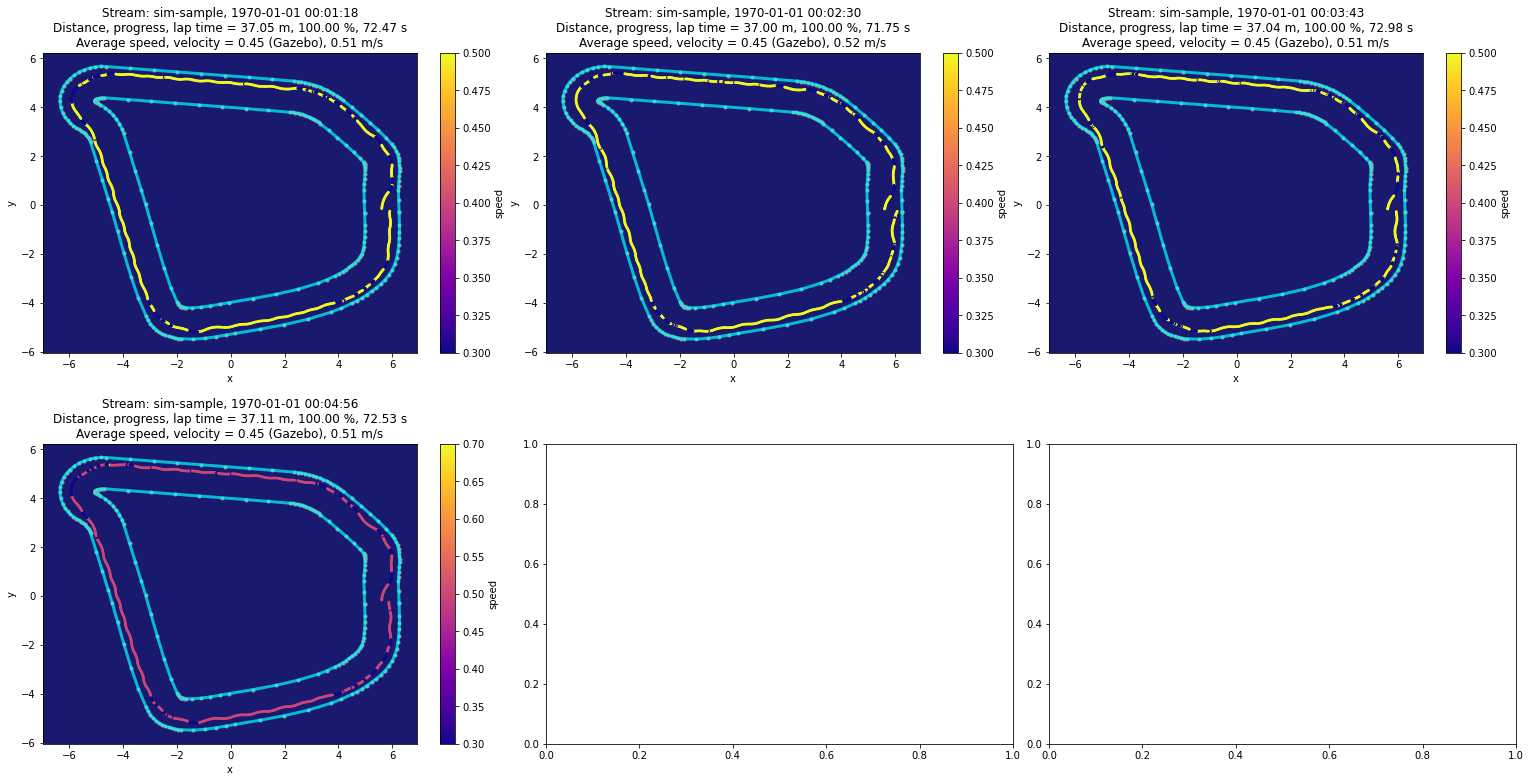

<Figure size 432x288 with 0 Axes>

In [11]:
pu.plot_evaluations(bulk, track)

## Single lap
Below you will find some ideas of looking at a single evaluation lap. You may be interested in a specific part of it. This isn't very robust but can work as a starting point. Please submit your ideas for analysis.

This place is a great chance to learn more about [Pandas](https://pandas.pydata.org/pandas-docs/stable/) and about how to process data series.

In [12]:
# Load a single lap
lap_df = bulk[(bulk['episode']==0) & (bulk['stream']=='sim-sample')]

We're adding a lot of columns here to the episode. To speed things up, it's only done per a single episode, so others will currently be missing this information.

Now try using them as a `graphed_value` parameter.

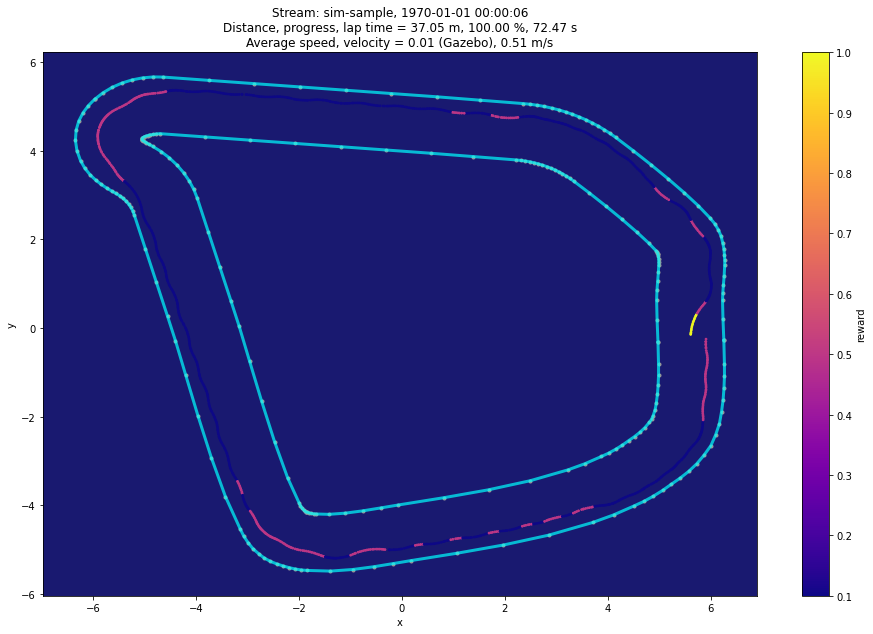

<Figure size 432x288 with 0 Axes>

In [13]:
lap_df.loc[:,'distance']=((lap_df['x'].shift(1)-lap_df['x']) ** 2 + (lap_df['y'].shift(1)-lap_df['y']) ** 2) ** 0.5
lap_df.loc[:,'time']=lap_df['tstamp'].astype(float)-lap_df['tstamp'].shift(1).astype(float)
lap_df.loc[:,'speed']=lap_df['distance']/(100*lap_df['time'])
lap_df.loc[:,'acceleration']=(lap_df['distance']-lap_df['distance'].shift(1))/lap_df['time']
lap_df.loc[:,'progress_delta']=lap_df['progress'].astype(float)-lap_df['progress'].shift(1).astype(float)
lap_df.loc[:,'progress_delta_per_time']=lap_df['progress_delta']/lap_df['time']

pu.plot_grid_world(lap_df, track, graphed_value='reward')

## Evaluation Run Analysis

Debug your evaluation runs or analyze the laps. By providing the evaluation simulation id you can fetch a single log file and use it. You can do the same for race submission but I recommend using the bulk solution above. If you still want to do it, make sure to add `log_group = "/aws/robomaker/leaderboard/SimulationJobs"` to `download_log` call.

In [14]:
#eval_sim = 'sim-sample'
#eval_fname = 'logs//deepracer-eval-%s.log' % eval_sim
#cw.download_log(eval_fname, stream_prefix=eval_sim)

In [15]:
#!head $eval_fname

In [16]:
#eval_df = slio.load_pandas(eval_fname)
#eval_df.head()

### Grid World Analysis
The code below visualises laps from a single log file just like the one above visualises it in bulk for many.

In [17]:
#eu.analyse_single_evaluation(eval_df, track)